In [ ]:
pip install catboost

In [2]:
#Data analysis & vizualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Modeling
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
#Data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
#Performance evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, KFold
#Removing noisy warnings in test runs
import warnings

In [3]:
warnings.filterwarnings("ignore")

In [4]:
#A copy is used for operations, leaving the original for reference
df = pd.read_csv("Melbourne_housing_FULL.csv")
df_copy = df.copy()

In [5]:
df_copy.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [6]:
print(
    f"Shape: {df_copy.shape} => {len(df_copy)} features & {len(df_copy.columns)} columns |",
    f"Size: {df_copy.size} |",
    f"Dimension: {df_copy.ndim}")

Shape: (34857, 21) => 34857 features & 21 columns | Size: 731997 | Dimension: 2


In [7]:
#Data type can be used as the basis for classifying features as either categorical or numerical
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

In [8]:
#Feature "Address" has too many unique values for a categorical feature
df_copy.nunique()

Suburb             351
Address          34009
Rooms               12
Type                 3
Price             2871
Method               9
SellerG            388
Date                78
Distance           215
Postcode           211
Bedroom2            15
Bathroom            11
Car                 15
Landsize          1684
BuildingArea       740
YearBuilt          160
CouncilArea         33
Lattitude        13402
Longtitude       14524
Regionname           8
Propertycount      342
dtype: int64

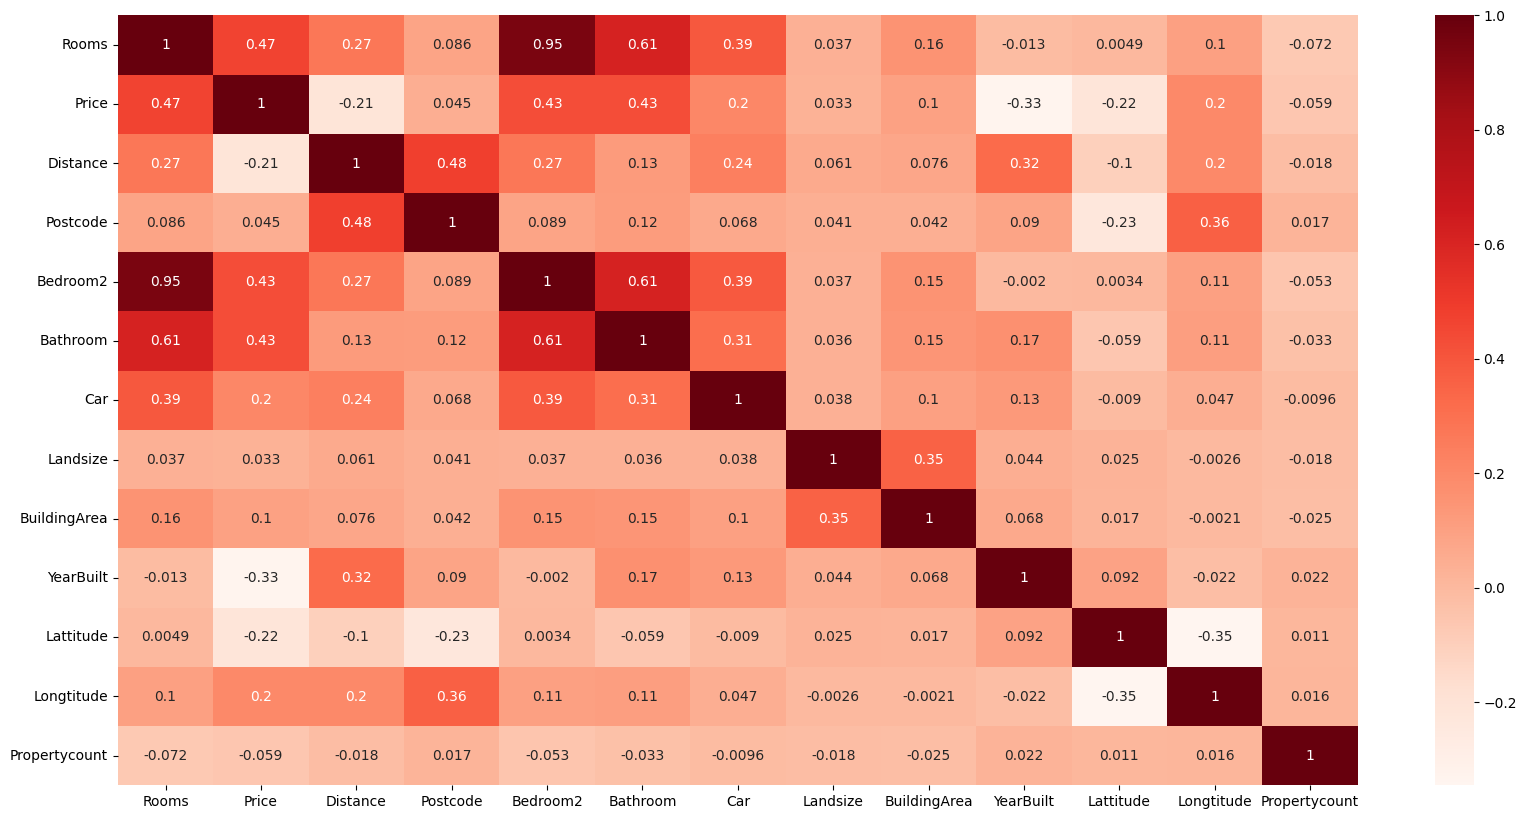

In [9]:
#Features "Rooms" and "Bedroom2" have very high correlation
corr = df_copy.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap="Reds", annot=True);

In [10]:
#Feature "Address" doesn't present any meaningful information
df_copy = df_copy.drop("Address", axis=1)
#Feature "Rooms" has near identical values
df_copy = df_copy.drop("Bedroom2", axis=1)
#For encoding
cat_cols = df_copy.select_dtypes(include=["object"]).columns
#For outlier detection, imputation and normalization
num_cols = df_copy.select_dtypes(include=["number"]).columns
#For correlation analysis
num_feature_cols = df_copy.select_dtypes(include=["number"]).columns.difference(["Price"])

In [11]:
df_copy.duplicated().sum()

24

In [12]:
df_copy.loc[df_copy.duplicated(keep=False), :]

,Suburb,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
1191,Balwyn North,4,h,NaN,SP,Marshall,28/05/2016,9.2,3104.0,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,7809.0
1192,Balwyn North,4,h,NaN,SP,Marshall,28/05/2016,9.2,3104.0,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,7809.0
2584,Burwood,4,t,1000050.0,S,Philip,18/06/2016,11.7,3125.0,NaN,NaN,NaN,NaN,NaN,Monash City Council,NaN,NaN,Southern Metropolitan,5678.0
2585,Burwood,4,t,1000050.0,S,Philip,18/06/2016,11.7,3125.0,NaN,NaN,NaN,NaN,NaN,Monash City Council,NaN,NaN,Southern Metropolitan,5678.0
2743,Camberwell,4,h,NaN,S,Marshall,22/05/2016,7.8,3124.0,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,8920.0
2744,Camberwell,4,h,NaN,S,Marshall,22/05/2016,7.8,3124.0,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,8920.0
2745,Camberwell,4,h,NaN,S,Marshall,22/05/2016,7.8,3124.0,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,8920.0
6422,Malvern East,4,h,NaN,S,Jellis,17/09/2016,11.2,3145.0,NaN,NaN,NaN,NaN,NaN,Stonnington City Council,NaN,NaN,Southern Metropolitan,8801.0
6423,Malvern East,4,h,NaN,S,Jellis,17/09/2016,11.2,3145.0,NaN,NaN,NaN,NaN,NaN,Stonnington City Council,NaN,NaN,Southern Metropolitan,8801.0
6604,Maribyrnong,2,u,NaN,W,hockingstuart,22/05/2016,8.7,3032.0,NaN,NaN,NaN,NaN,NaN,Maribyrnong City Council,NaN,NaN,Western Metropolitan,4918.0


In [13]:
df_copy = df_copy.drop_duplicates()
df_copy = df_copy.reset_index(drop=True)

In [14]:
#Features "Distance", "Landsize" and "BuildingArea" have unusual 0 values
df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,34833.0,3.031034e+00,0.969971,1.00000,2.00000,3.0000,4.000000e+00,1.600000e+01
Price,27237.0,1.050246e+06,641552.339232,85000.00000,635000.00000,870000.0000,1.295000e+06,1.120000e+07
Distance,34832.0,1.118497e+01,6.786942,0.00000,6.40000,10.3000,1.400000e+01,4.810000e+01
Postcode,34832.0,3.116029e+03,108.936190,3000.00000,3051.00000,3103.0000,3.156000e+03,3.978000e+03
Bathroom,26630.0,1.624747e+00,0.724177,0.00000,1.00000,2.0000,2.000000e+00,1.200000e+01
Car,26128.0,1.728835e+00,1.010789,0.00000,1.00000,2.0000,2.000000e+00,2.600000e+01
Landsize,23046.0,5.936072e+02,3398.915462,0.00000,224.00000,521.0000,6.700000e+02,4.330140e+05
BuildingArea,13741.0,1.602516e+02,401.281270,0.00000,102.00000,136.0000,1.880000e+02,4.451500e+04
YearBuilt,15550.0,1.965288e+03,37.328340,1196.00000,1940.00000,1970.0000,2.000000e+03,2.106000e+03
Lattitude,26880.0,-3.781063e+01,0.090281,-38.19043,-37.86295,-37.8076,-3.775409e+01,-3.739020e+01


In [15]:
#Feature "Landsize" has highly skewed distribution of values
for col in num_cols:
  print(col, "\n", df_copy[col].value_counts(), "\n", sep="")

Rooms
3     15077
2      8325
4      7947
5      1737
1      1478
6       204
7        32
8        19
10        6
9         4
12        3
16        1
Name: Rooms, dtype: int64

Price
1100000.0    235
600000.0     235
650000.0     219
800000.0     216
1300000.0    210
            ... 
1452000.0      1
2555000.0      1
949500.0       1
426500.0       1
1605500.0      1
Name: Price, Length: 2871, dtype: int64

Distance
11.2    1418
13.8     681
9.2      664
10.5     660
7.8      660
        ... 
31.4       1
22.9       1
33.0       1
29.5       1
32.6       1
Name: Distance, Length: 215, dtype: int64

Postcode
3073.0    844
3046.0    638
3020.0    617
3121.0    612
3165.0    583
         ... 
3428.0      1
3770.0      1
3786.0      1
3139.0      1
3159.0      1
Name: Postcode, Length: 211, dtype: int64

Bathroom
1.0     12969
2.0     11064
3.0      2180
4.0       269
5.0        77
0.0        46
6.0        16
7.0         4
8.0         3
12.0        1
9.0         1
Name: Bathroom, dtype: in

In [16]:
percentage1 = (df_copy["BuildingArea"] == 0).sum() / len(df) * 100
percentage2 = (df_copy["Distance"] == 0).sum() / len(df) * 100
percentage3 = (df_copy["Landsize"] == 0).sum() / len(df) * 100
print(f"Building Area 0 values: {percentage1:.3f}% | Distance 0 values: {percentage2:.3f}% | Land Size 0 values: {percentage3:.3f}%")

Building Area 0 values: 0.218% | Distance 0 values: 0.221% | Land Size 0 values: 6.991%


In [17]:
df_copy.isnull().sum()

Suburb               0
Rooms                0
Type                 0
Price             7596
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bathroom          8203
Car               8705
Landsize         11787
BuildingArea     21092
YearBuilt        19283
CouncilArea          3
Lattitude         7953
Longtitude        7953
Regionname           3
Propertycount        3
dtype: int64

In [18]:
df_copy.isnull().sum() / len(df_copy) * 100

Suburb            0.000000
Rooms             0.000000
Type              0.000000
Price            21.806907
Method            0.000000
SellerG           0.000000
Date              0.000000
Distance          0.002871
Postcode          0.002871
Bathroom         23.549508
Car              24.990670
Landsize         33.838601
BuildingArea     60.551776
YearBuilt        55.358424
CouncilArea       0.008613
Lattitude        22.831797
Longtitude       22.831797
Regionname        0.008613
Propertycount     0.008613
dtype: float64

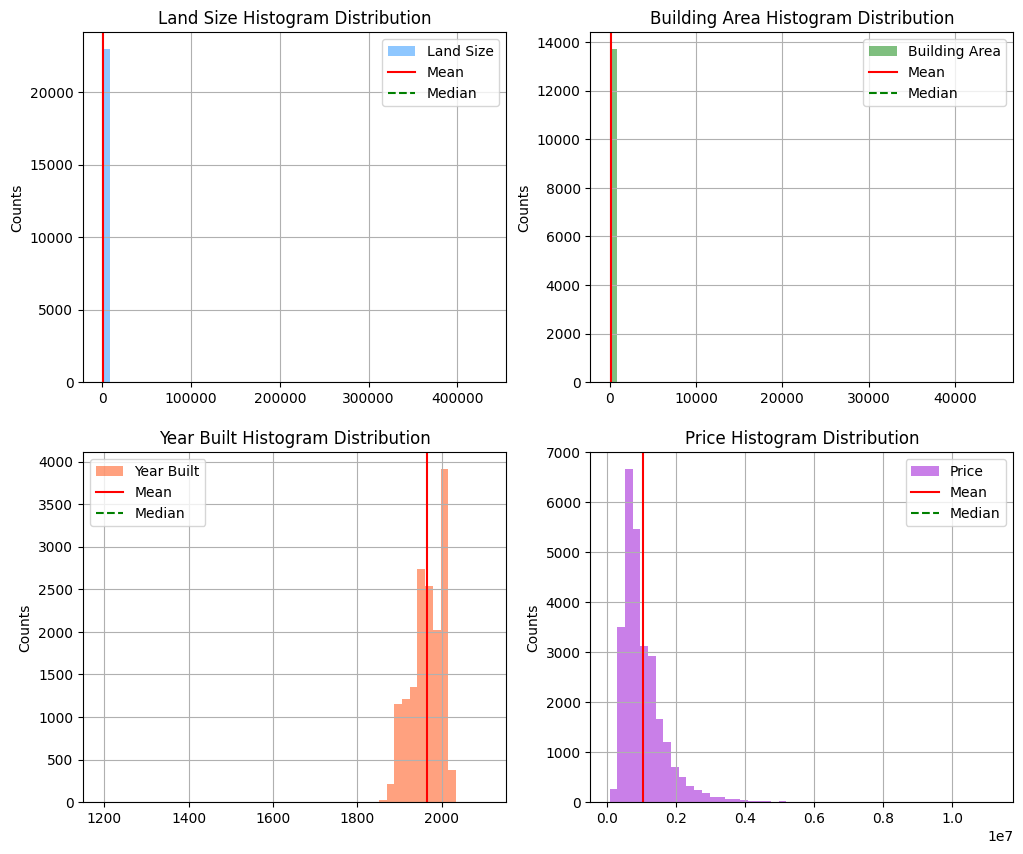

In [19]:
#Distributions before data processing
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
df_copy["Landsize"].hist(bins=50, color="dodgerblue", label="Land Size", alpha=0.5)
plt.axvline(np.mean(df_copy["Landsize"]), ls="-", c="r", label="Mean")
plt.axvline(np.median(df_copy["Landsize"]), ls="--", c="g", label="Median")
plt.ylabel("Counts")
plt.title("Land Size Histogram Distribution");
plt.legend()

plt.subplot(2, 2, 2)
df_copy["BuildingArea"].hist(bins=50, color="green", label="Building Area", alpha=0.5)
plt.axvline(np.mean(df_copy["BuildingArea"]), ls="-", c="r", label="Mean")
plt.axvline(np.median(df_copy["BuildingArea"]), ls="--", c="g", label="Median")
plt.ylabel("Counts")
plt.title("Building Area Histogram Distribution");
plt.legend()

plt.subplot(2, 2, 3)
df_copy["YearBuilt"].hist(bins=50, color="orangered", label="Year Built", alpha=0.5)
plt.axvline(np.mean(df_copy["YearBuilt"]), ls="-", c="r", label="Mean")
plt.axvline(np.median(df_copy["YearBuilt"]), ls="--", c="g", label="Median")
plt.ylabel("Counts")
plt.title("Year Built Histogram Distribution");
plt.legend()

plt.subplot(2, 2, 4)
df_copy["Price"].hist(bins=50, color="darkviolet", label="Price", alpha=0.5)
plt.axvline(np.mean(df_copy["Price"]), ls="-", c="r", label="Mean")
plt.axvline(np.median(df_copy["Price"]), ls="--", c="g", label="Median")
plt.ylabel("Counts")
plt.title("Price Histogram Distribution");
plt.legend()

In [20]:
#0 values for "Landsize", "BuildingArea" and "Distance" are classified as missing values
df_copy["Landsize"].replace(0, np.nan, inplace=True)
df_copy["BuildingArea"].replace(0, np.nan, inplace=True)
df_copy["Distance"].replace(0, np.nan, inplace=True)

In [21]:
#Modified version of z-score is used for skewed data
def modified_zscore_clear(df, num_cols, threshold):
  for col in num_cols:
    median = df[col].median()
    MAD = df[col].mad()
    df["modified_z_score"] = 0.6745 * (df[col] - median) / MAD
    df[col][abs(df["modified_z_score"]) > threshold] = np.nan

In [22]:
modified_zscore_clear(df_copy, num_cols, 3)
#Eliminating the byproduct of the function
df_copy = df_copy.drop("modified_z_score", axis=1)

In [23]:
#Excluding labels from imputation reduces risk of data leakage and bias
df_copy.dropna(subset=["Price"], inplace=True)

In [24]:
#Scaling makes values more consistent and increase model speed
scaler = MinMaxScaler()
num_features = df_copy.select_dtypes(include=["number"]).drop(columns=["Price"])
scaled_features = scaler.fit_transform(num_features)
scaled_df = pd.DataFrame(scaled_features, index=num_features.index, columns=num_features.columns)
df_copy.update(scaled_df)
df_copy.head()

,Suburb,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
1,Abbotsford,0.2,h,1480000.0,S,Biggin,3/12/2016,0.056962,0.197059,0.25,0.2,0.091697,NaN,NaN,Yarra City Council,0.513211,0.494988,Northern Metropolitan,0.182501
2,Abbotsford,0.2,h,1035000.0,S,Biggin,4/02/2016,0.056962,0.197059,0.25,0.0,0.070712,0.179724,0.295858,Yarra City Council,0.499690,0.488571,Northern Metropolitan,0.182501
4,Abbotsford,0.4,h,1465000.0,SP,Biggin,4/03/2017,0.056962,0.197059,0.50,0.0,0.060675,0.343318,0.295858,Yarra City Council,0.497410,0.489855,Northern Metropolitan,0.182501
5,Abbotsford,0.4,h,850000.0,PI,Biggin,4/03/2017,0.056962,0.197059,0.50,0.2,0.042427,NaN,NaN,Yarra City Council,0.517610,0.493063,Northern Metropolitan,0.182501
6,Abbotsford,0.6,h,1600000.0,VB,Nelson,4/06/2016,0.056962,0.197059,0.25,0.4,0.054288,0.324885,0.970414,Yarra City Council,0.500831,0.489470,Northern Metropolitan,0.182501


In [25]:
for col in cat_cols:
  df_copy[col] = df_copy[col].fillna(df_copy[col].mode().iloc[0])

num_imputer = KNNImputer(n_neighbors=50)
df_copy[num_cols] = num_imputer.fit_transform(df_copy[num_cols])

In [26]:
df_copy.isnull().sum()

Suburb           0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64

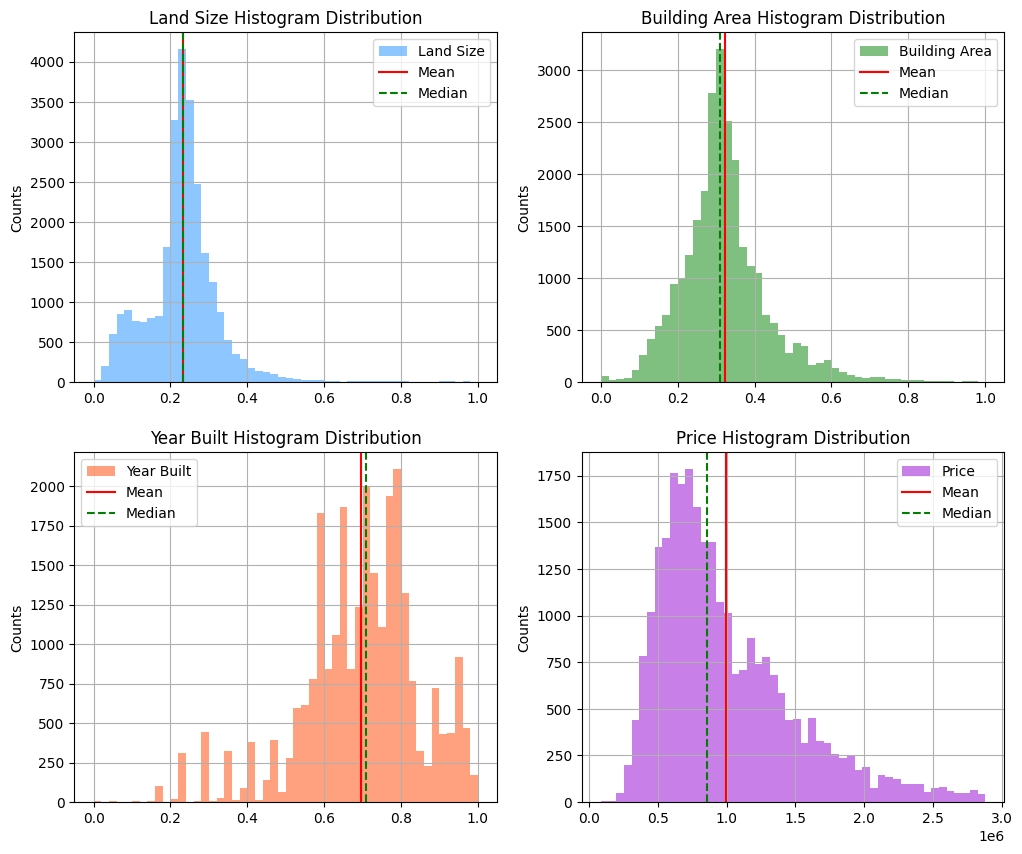

In [27]:
#Distributions after data processing
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
df_copy["Landsize"].hist(bins=50, color="dodgerblue", label="Land Size", alpha=0.5)
plt.axvline(np.mean(df_copy["Landsize"]), ls="-", c="r", label="Mean")
plt.axvline(np.median(df_copy["Landsize"]), ls="--", c="g", label="Median")
plt.ylabel("Counts")
plt.title("Land Size Histogram Distribution");
plt.legend()

plt.subplot(2, 2, 2)
df_copy["BuildingArea"].hist(bins=50, color="green", label="Building Area", alpha=0.5)
plt.axvline(np.mean(df_copy["BuildingArea"]), ls="-", c="r", label="Mean")
plt.axvline(np.median(df_copy["BuildingArea"]), ls="--", c="g", label="Median")
plt.ylabel("Counts")
plt.title("Building Area Histogram Distribution");
plt.legend()

plt.subplot(2, 2, 3)
df_copy["YearBuilt"].hist(bins=50, color="orangered", label="Year Built", alpha=0.5)
plt.axvline(np.mean(df_copy["YearBuilt"]), ls="-", c="r", label="Mean")
plt.axvline(np.median(df_copy["YearBuilt"]), ls="--", c="g", label="Median")
plt.ylabel("Counts")
plt.title("Year Built Histogram Distribution");
plt.legend()

plt.subplot(2, 2, 4)
df_copy["Price"].hist(bins=50, color="darkviolet", label="Price", alpha=0.5)
plt.axvline(np.mean(df_copy["Price"]), ls="-", c="r", label="Mean")
plt.axvline(np.median(df_copy["Price"]), ls="--", c="g", label="Median")
plt.ylabel("Counts")
plt.title("Price Histogram Distribution");
plt.legend()

In [28]:
correlations_with_price = df_copy.corrwith(df_copy["Price"])
correlations_with_price.sort_values(ascending=False)

Price            1.000000
BuildingArea     0.692195
Rooms            0.470888
Bathroom         0.419962
Longtitude       0.249920
Postcode         0.240939
Car              0.216939
Landsize         0.127674
Propertycount   -0.074306
Distance        -0.205485
Lattitude       -0.290580
YearBuilt       -0.503876
dtype: float64

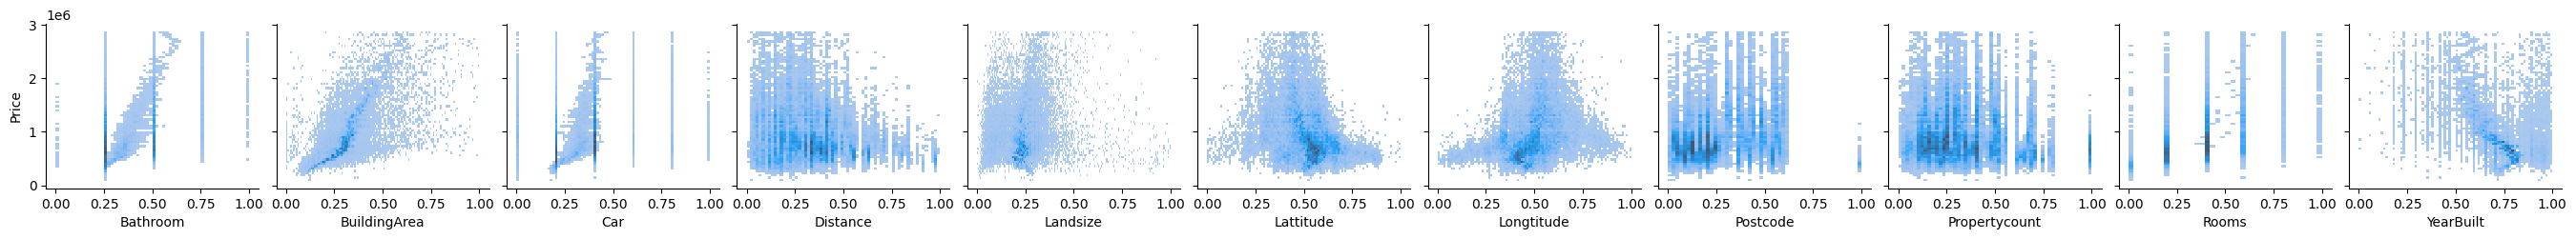

In [29]:
sns.pairplot(df_copy, x_vars=num_feature_cols, y_vars=["Price"], kind="hist")
plt.show()

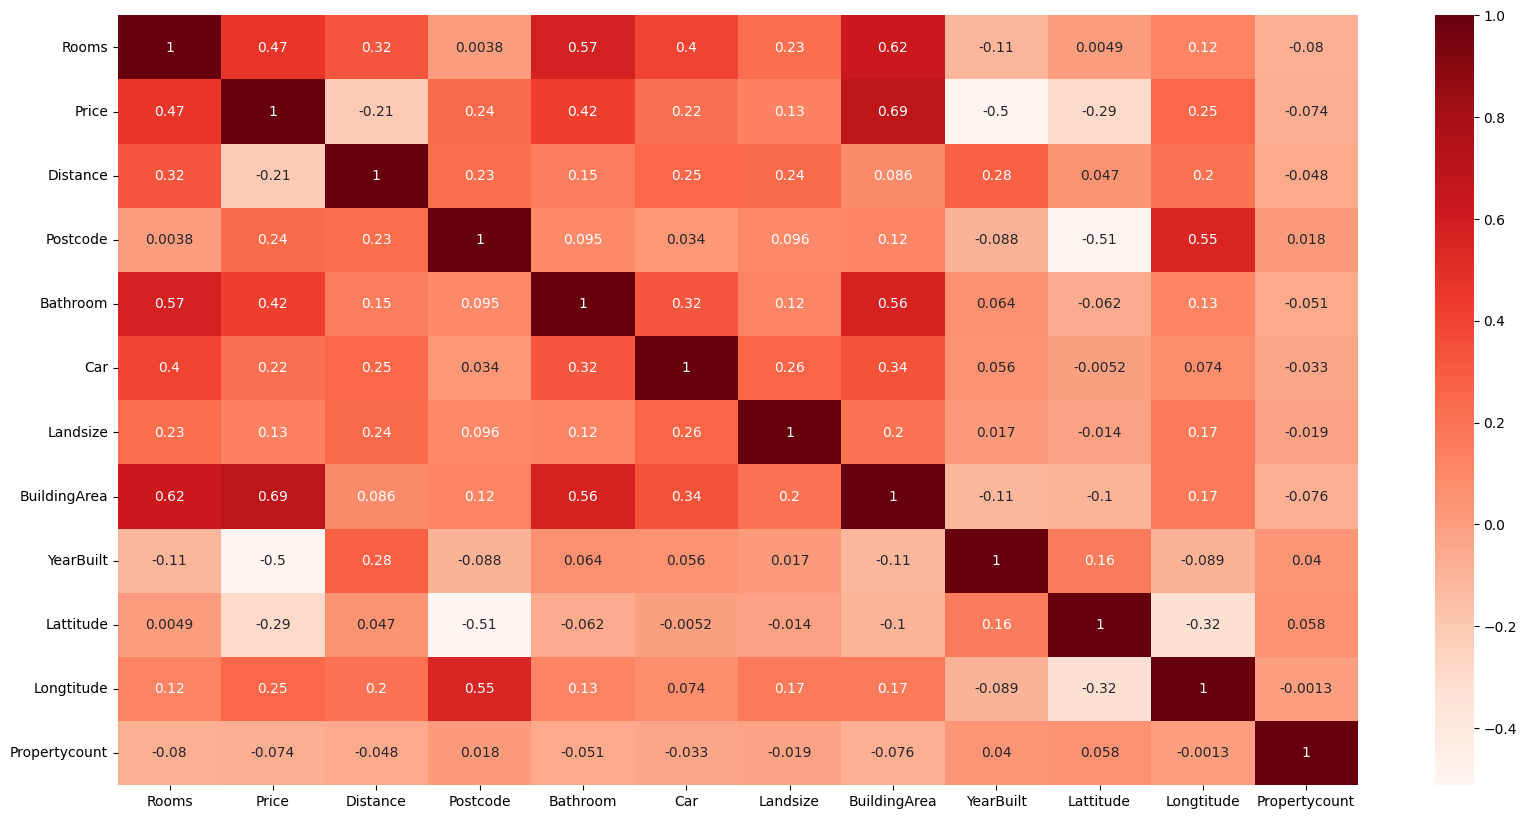

In [30]:
#Useful for identifying which features are more predictive of label
corr = df_copy.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap="Reds", annot=True);

In [31]:
#Despite not being ordinal variables, Suburb" and "SellerG" are encoded with label encoder to reduce DataFrame dimension, increase model speed and decrease memory usage
label_encoder = LabelEncoder()
cat_cols_label = ["Suburb", "SellerG"]
for col in cat_cols_label:
  df_copy[col] = label_encoder.fit_transform(df_copy[col])

cat_cols_one_hot = [col for col in cat_cols if col not in cat_cols_label]
df_copy = pd.get_dummies(df_copy, columns=cat_cols_one_hot, drop_first=True)
df_copy.head()

,Suburb,Rooms,Price,SellerG,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,...,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
1,0,0.2,1480000.0,32,0.056962,0.197059,0.25,0.2,0.091697,0.388111,...,0,1,0,0,1,0,0,0,0,0
2,0,0.2,1035000.0,32,0.056962,0.197059,0.25,0.0,0.070712,0.179724,...,0,1,0,0,1,0,0,0,0,0
4,0,0.4,1465000.0,32,0.056962,0.197059,0.50,0.0,0.060675,0.343318,...,0,1,0,0,1,0,0,0,0,0
5,0,0.4,850000.0,32,0.056962,0.197059,0.50,0.2,0.042427,0.317416,...,0,1,0,0,1,0,0,0,0,0
6,0,0.6,1600000.0,205,0.056962,0.197059,0.25,0.4,0.054288,0.324885,...,0,1,0,0,1,0,0,0,0,0


In [32]:
X = df_copy.drop("Price", axis=1)
y = df_copy.loc[:,"Price"]

In [33]:
df_copy.shape

(26702, 136)

In [34]:
#Random state is used as a consistent reference point
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [ ]:
models = {
"Lasso": Lasso(),
"Linear": LinearRegression(),
"Ridge": Ridge(),
"Elastic Net": ElasticNet(),
"K Neighbors": KNeighborsRegressor(),
"Random Forest": RandomForestRegressor(),
"Gradient Boosting": GradientBoostingRegressor(),
"Ada Boost": AdaBoostRegressor(n_estimators=5, learning_rate=1.2, loss="exponential", random_state=2),
"XGB": XGBRegressor(),
"LGBM": LGBMRegressor(),
"Cat Boost": CatBoostRegressor()
}

model_names = []
model_preds = {}

for name, model in models.items():
  model.fit(X_train, y_train)
  prediction = model.predict(X_test)
  model_names.append(name)
  model_preds[name] = prediction

In [36]:
r2_scores = {}

for name, pred in model_preds.items():
  print(f"{name}\n=========================")
  print(f"MAE: {mean_absolute_error(y_test, pred):.0f}")
  print(f"MSE: {mean_squared_error(y_test, pred):.0f}")
  print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred)):.0f}")
  print(f"R2: {r2_score(y_test, pred):.3f}", end="\n\n")
  r2_scores[name] = r2_score(y_test, pred).round(3)

Lasso
MAE: 166661
MSE: 52607746207
RMSE: 229364
R2: 0.789

Linear
MAE: 166676
MSE: 52612518967
RMSE: 229374
R2: 0.789

Ridge
MAE: 166642
MSE: 52597774825
RMSE: 229342
R2: 0.789

Elastic Net
MAE: 329328
MSE: 183227010646
RMSE: 428050
R2: 0.266

K Neighbors
MAE: 245352
MSE: 120524253934
RMSE: 347166
R2: 0.517

Random Forest
MAE: 93706
MSE: 24931330028
RMSE: 157897
R2: 0.900

Gradient Boosting
MAE: 113732
MSE: 31183194589
RMSE: 176588
R2: 0.875

Ada Boost
MAE: 175871
MSE: 60350846444
RMSE: 245664
R2: 0.758

XGB
MAE: 99646
MSE: 23871267130
RMSE: 154503
R2: 0.904

LGBM
MAE: 97962
MSE: 23143915747
RMSE: 152131
R2: 0.907

Cat Boost
MAE: 96190
MSE: 21696999446
RMSE: 147299
R2: 0.913



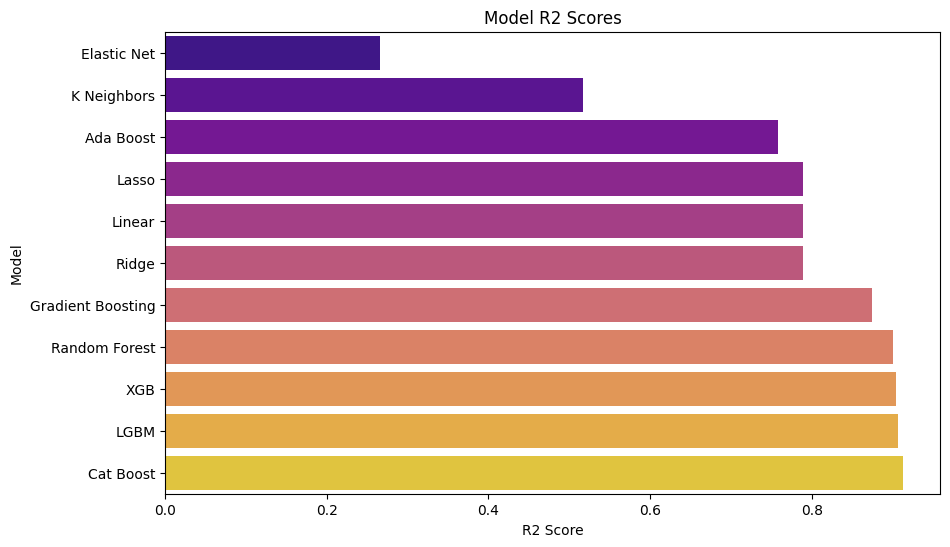

In [37]:
df = pd.DataFrame({'Model': model_names, 'R2 Score': r2_scores.values()})
df = df.sort_values(by='R2 Score', ascending=True)

plt.figure(figsize=(10, 6))

sns.barplot(data=df, x='R2 Score', y='Model', palette="plasma")
plt.xlabel("R2 Score")
plt.title("Model R2 Scores")

plt.show()

In [ ]:
#Cross validating top 3 performing models to see how they generalize to data
xgb = XGBRegressor().fit(X_train, y_train)
lgbm = LGBMRegressor().fit(X_train, y_train)
cb = CatBoostRegressor().fit(X_train, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

xgb_r2 = cross_val_score(xgb, X, y, cv=kf, scoring=make_scorer(r2_score))
lgbm_r2 = cross_val_score(lgbm, X, y, cv=kf, scoring=make_scorer(r2_score))
cb_r2 = cross_val_score(cb, X, y, cv=kf, scoring=make_scorer(r2_score))

In [39]:
xgb_r2 = [f"{value:.3f}" for value in xgb_r2]
lgbm_r2 = [f"{value:.3f}" for value in lgbm_r2]
cb_r2 = [f"{value:.3f}" for value in cb_r2]

print(f"XGB R2 scores: {xgb_r2}", end="\n\n")
print(f"LGM R2 scores: {lgbm_r2}", end="\n\n")
print(f"Cat Boost R2 scores: {cb_r2}", end="\n\n")

XGB R2 scores: ['0.907', '0.902', '0.900', '0.911', '0.908']

LGM R2 scores: ['0.909', '0.904', '0.901', '0.911', '0.909']

Cat Boost R2 scores: ['0.915', '0.913', '0.910', '0.918', '0.915']

